# Stochastic

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
import scipy as sp

def reliability(beta0_b, d_b, L_b, Thoriz):
    # --- Reliability estimation
    # beta_bt: reliability curve over time for bridge b
    # beta0_b: Initial reliability of bridge b at t=0
    # d_b, L_b: when the degradation starts and reaches beta=0 for each bridge
    # Thoriz: maximum time studied
    nb = len(beta0_b)
    beta_bt = np.zeros((nb, Thoriz))
    
    for b in range(nb):
        #horziontal branch
        timesteps = int(np.floor(d_b[b]))
        beta_bt[b, :timesteps] = beta0_b[b]
        
        #degradation till L_b
        servicelife = int(np.floor(L_b[b]))
        t = np.arange(timesteps + 1, servicelife + 1)
        beta_bt[b, timesteps:servicelife] = beta0_b[b] / (L_b[b] - d_b[b]) * (L_b[b] - t)
    
    return beta_bt

def MaintenanceApplication(beta_bt, X_bt, Thoriz):
    # --- Given a maintenance strategy given by X_bt, where 1 means that bridge
    # b undergoes maintenance at time t, this function gives the updated
    # reliability profile
    updatedbeta_bt = beta_bt.copy()
    InterventionTimes = np.where(np.sum(X_bt, axis=0) > 0)[0]
    
    for t in InterventionTimes:
        intervbrid = np.where(X_bt[:, t] == 1)[0]
        timecells = Thoriz - t - 1
        updatedbeta_bt[intervbrid, t+1:Thoriz] = beta_bt[intervbrid, :timecells]
    
    return updatedbeta_bt

def Frequency2Schedule(y_b, nb, nt, Thoriz):
    # Transforms a vector indicating the frequency to a schedule matrix [0/1]
    freq_b = y_b.reshape((nt, nb)).T
    cumFreq_b = cumulateFreq(freq_b)
    X_bt = np.zeros((nb, Thoriz))
    
    for b in range(nb):
        idx = cumFreq_b[b, cumFreq_b[b, :] != 0].astype(int)
        idx = idx[idx <= Thoriz]
        if len(idx) > 0:
            X_bt[b, idx - 1] = 1
    
    return X_bt

def cumulateFreq(freq_b):
    # creates the cumulative frequency
    nb, nt = freq_b.shape
    cumFreq_b = np.zeros((nb, nt))
    
    for b in range(nb):
        f_b = freq_b[b, freq_b[b, :] != 0]
        cumFreq_b[b, :len(f_b)] = np.cumsum(f_b)
    
    return cumFreq_b

def CountNinterv(y_b, nt, nb):
    # from vector y_b, it computes the number of interventions per bridge
    y_b01 = y_b != 0
    freq_b = y_b01.reshape((nt, nb)).T
    ninterv_b = np.sum(freq_b, axis=1)
    return ninterv_b

def ProbFulfilment(beta_bti0, X_bt, Thoriz):
    nb, _, nMCS = beta_bti0.shape

    # --- MCS
    Achivement_bi = np.zeros((nb, nMCS))
    for i in range(nMCS):
        beta_bt = MaintenanceApplication(beta_bti0[:, :, i], X_bt, Thoriz)
        failures_b = np.sum(beta_bt == 0, axis=1)
        Achivement_bi[:, i] = (failures_b == 0)
    
    ProbRel_b = np.sum(Achivement_bi, axis=1) / nMCS
    return ProbRel_b

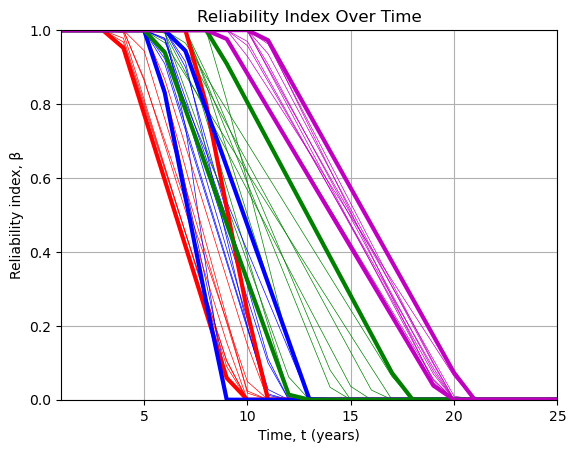

In [26]:


Thoriz = 25
# for each bridge b:  beta0 mu_d(years) sigma_d(years) mu_L(years) sigma_L(years) C(Meuros)
data = np.array([
    [1, 5, 2 / 1.96, 10, 1 / 1.96, 0.6],
    [1, 6, 1 / 1.96, 11, 2 / 1.96, 0.8],
    [1, 7, 1 / 1.96, 15, 5 / 1.96, 1.0],
    [1, 10, 1 / 1.96, 20, 1 / 1.96, 0.7]
])
beta0_b, mud_b, sigd_b, muL_b, sigL_b, C_b = data[:, 0], data[:, 1], data[:, 2], data[:, 3], data[:, 4], data[:, 5]

# Annual resources (M euro)
R = 1.4

# Sample size of the probabilistic analysis
nMCS=10

# --- Initial reliability estimation
nb = len(beta0_b)  # number of bridges

# nMCS cases of d and L
d_bi, L_bi = np.zeros((nb, nMCS)), np.zeros((nb, nMCS))
for b in range(nb):
    d_bi[b, :] = np.random.normal(mud_b[b], sigd_b[b], nMCS)
    L_bi[b, :] = np.random.normal(muL_b[b], sigL_b[b], nMCS)

beta_bti0 = np.zeros((nb, Thoriz, nMCS))
for i in range(nMCS):
    beta_bti0[:, :, i] = reliability(beta0_b, d_bi[:, i], L_bi[:, i], Thoriz)  # reliability with time

plt.figure()
col = ['r', 'b', 'g', 'm']
for i in range(nMCS):
    for b in range(nb):
        plt.plot(range(1, Thoriz + 1), beta_bti0[b, :, i], f'-{col[b]}', linewidth=0.5)
for b in range(nb):
    minbeta_t0 = reliability([beta0_b[b]], [np.min(d_bi[b, :])], [np.min(L_bi[b, :])], Thoriz)[0,:]  # min reliability
    maxbeta_t0 = reliability([beta0_b[b]], [np.max(d_bi[b, :])], [np.max(L_bi[b, :])], Thoriz)[0,:]  # max reliability
    plt.plot(range(1, Thoriz + 1), minbeta_t0, f'-{col[b]}', linewidth=3)
    plt.plot(range(1, Thoriz + 1), maxbeta_t0, f'-{col[b]}', linewidth=3)
plt.grid()
plt.xlim([1, Thoriz])
plt.ylim([0, 1])
plt.xlabel('Time, t (years)')
plt.ylabel('Reliability index, β')
plt.title('Reliability Index Over Time')
plt.show()

# Deterministic Optimization
# Variables ->  e.g., freq=[10 2 0 0 ; 5, 5 0 0; 0 0 0 0];  

maxInter_b = np.ceil(Thoriz / np.min(L_bi, axis=1)).astype(int) + 1  # max number of interventions expected per bridge given by the lowest service life
nt = max(maxInter_b)  # to dimension the matrix, max interventions experienced by the worst case. 
nvars = nb * nt #number of design variables
integers = np.array([True] * nvars) #all variables are integers

#  Range of definition: [0,max number of years with no interventions==L_b]

lb = np.zeros((nvars, 1))
# upper bound
ub = lb.copy()
pos = 0
for b in range(nb):
    # This guarantees interventions freq. within the service life (if conducted)
    ub[pos:pos + maxInter_b[b]] = np.max(L_bi[b, :], axis=0) - 1  # the largest service life is of relevance here
    # this forces zeros after the max number of interventions expected
    if maxInter_b[b] < nb:
        ub[pos + maxInter_b[b]:pos + nb - 1] = 0
    pos += nt
ub = np.ceil(ub)

def nonlcon(y_b):
    #  From frequency to a schedule matrix [0/1]
    X_bt = Frequency2Schedule(y_b, nb, nt, Thoriz)
    
    # Constraint 1 >>> the last intervention is within Thoriz --> LastInterv<Thoriz --> LastInterv-Thoriz<=1   for all b
    lastInterv_b = np.max(cumulateFreq(y_b.reshape((nt, nb)).T), axis=1)
    c1 = lastInterv_b - Thoriz - 1

    # Constraint 2 >>> C_b*X_bt <= R   for all t
    c2 = np.sum(C_b[:, None] * X_bt, axis=0) - R

    # Constraint 3 >>> Prob(beta_bt>0)>=0.90  --> sum(sum(beta_bt))<=0 for all b
    ProbRel_b = ProbFulfilment(beta_bti0, X_bt, Thoriz)
    c3 = 0.90 - ProbRel_b

    c = np.concatenate([c1, c2, c3])
    return c

cons = sp.optimize.NonlinearConstraint(nonlcon, np.array([-np.inf] * (nb + Thoriz + nb)), np.array([0] * (nb + Thoriz + nb)))

def fun(y_b):
    #  minimize cost trying to go for the largest time between interventions (== max y_b)
    ninterv_b = CountNinterv(y_b, nt, nb)
    return np.dot(C_b, ninterv_b)

bounds = [[lb[i][0], ub[i][0]] for i in range(nvars)]

In [27]:
result = differential_evolution(fun, bounds, constraints=cons, integrality=integers, disp = True, maxiter = 2000)
print(result.x)

differential_evolution step 1: f(x)= 11.7
differential_evolution step 2: f(x)= 11.7
differential_evolution step 3: f(x)= 11.7
differential_evolution step 4: f(x)= 9.3
differential_evolution step 5: f(x)= 9.3
differential_evolution step 6: f(x)= 9.3
differential_evolution step 7: f(x)= 9.3
differential_evolution step 8: f(x)= 9.3
differential_evolution step 9: f(x)= 9.3
differential_evolution step 10: f(x)= 9.3
differential_evolution step 11: f(x)= 9.3
differential_evolution step 12: f(x)= 9.3
differential_evolution step 13: f(x)= 9.3
differential_evolution step 14: f(x)= 9.3
differential_evolution step 15: f(x)= 9.3
differential_evolution step 16: f(x)= 9.3
differential_evolution step 17: f(x)= 9.3
differential_evolution step 18: f(x)= 9.3
differential_evolution step 19: f(x)= 9.3
differential_evolution step 20: f(x)= 9.3
differential_evolution step 21: f(x)= 9.3
differential_evolution step 22: f(x)= 9.3
differential_evolution step 23: f(x)= 9.3
differential_evolution step 24: f(x)= 9.

Min Cost = 6.10
Number of interventions = 8
Number of time intervals with exceeding budget = 0
Prob(reliability>0) for bridge 1 = 1.0000
Prob(reliability>0) for bridge 2 = 0.9000
Prob(reliability>0) for bridge 3 = 1.0000
Prob(reliability>0) for bridge 4 = 1.0000


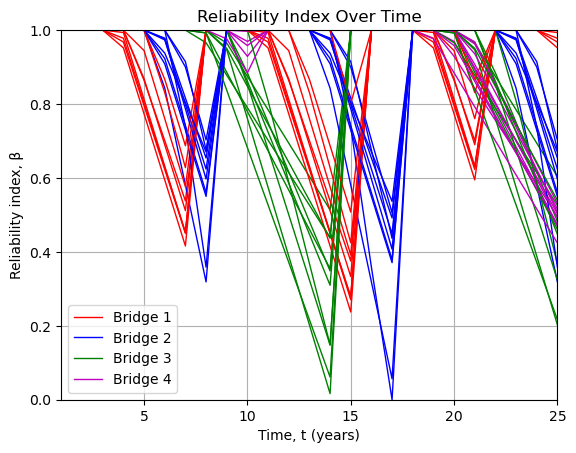

In [29]:
Yopt = result.x
OptInterv = cumulateFreq(Yopt.reshape((nt, nb)).T)
X_bt = Frequency2Schedule(Yopt, nb, nt, Thoriz)

print(f'Min Cost = {result.fun:.2f}')
ninterv = np.sum(CountNinterv(Yopt, nt, nb))
print(f'Number of interventions = {ninterv}')
c = nonlcon(Yopt)
BudgetIssues = np.sum(c[-Thoriz - 1:-1] > 0)
print(f'Number of time intervals with exceeding budget = {BudgetIssues}')
for b in range(1, nb + 1):
    probfulfilment = 0.90 - c[-nb + b - 1]
    print(f'Prob(reliability>0) for bridge {b} = {probfulfilment:.4f}')

plt.figure()
h = []
leg = []
for i in range(nMCS):
    beta_bt = MaintenanceApplication(beta_bti0[:, :, i], X_bt, Thoriz)  # optimal maintenance
    for b in range(nb):
        h.append(plt.plot(range(1, Thoriz + 1), beta_bt[b, :], f'-{col[b]}', linewidth=1))
        if i == 0:
            leg.append(f'Bridge {b + 1}')
plt.legend(leg, loc='best')
plt.grid()
plt.xlim([1, Thoriz])
plt.ylim([0, 1])
plt.xlabel('Time, t (years)')
plt.ylabel('Reliability index, β')
plt.title('Reliability Index Over Time')
plt.show()